# 시계열 데이터(Time Series Data) 예측
trend(), seasonality(), noise() 함수는 각각 경향성, 계절성, 노이즈를 갖는 시계열 데이터를 반환

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

'''plot_series() 함수'''
# 임의의 시간 값 (time), 시계열 데이터 (series)를 입력받아
# Matplotlib 그래프로 나타내는 함수
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

'''trend() 함수'''
# 경향성을 갖는 시계열 데이터를 반환
# slope 값에 따라서 시간에 따라 양의 경향성, 음의 경향성을 가질 수 있음
def trend(time, slope=0):
    return slope * time

'''seasonal_pattern() 함수'''
# 입력 season_time에 대해서 0.6보다 작은 경우에는 np.cos(season_time * 2 * np.pi) 값을,
# 그렇지 않은 경우에는 1 / np.exp(3 * season_time)을 반환
def seasonal_pattern(season_time):
    return np.where(season_time < 0.6,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

'''seasonality() 함수'''
# 주어진 주기 period에 대해 특정 값을 반복하는 시계열 데이터를 반환하는 함수
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

'''noise() 함수'''
# 0에서 noise_level 값 사이의 임의의 실수를 갖는 시계열 데이터를 반환
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
time = np.arange(4*365+1, dtype="float32")
baseline=10
# 길이 4 * 365 + 1의 시간 동안 시간에 따라 0.1의 기울기를 갖는 시계열 데이터
series = trend(time, 0.1)
amplitude=40 # 진폭
slope=0.01
noise_level=2

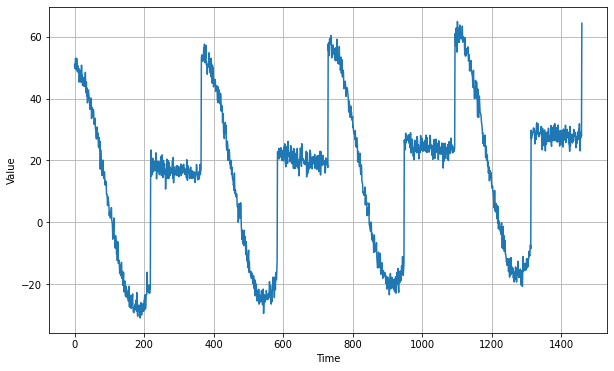

In [5]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## 시계열 데이터 train, test split

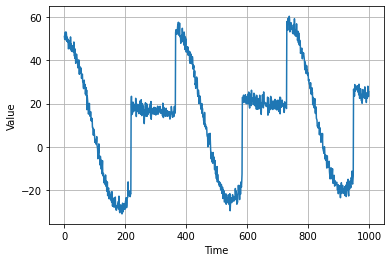

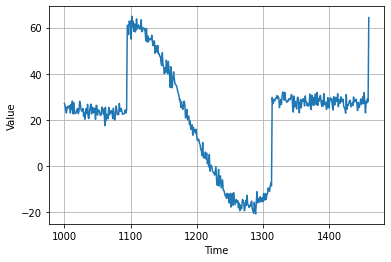

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time_train, x_train)
plt.show()

plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast
: 이전의 데이터를 다음 값으로 예측하는 시계열 데이터

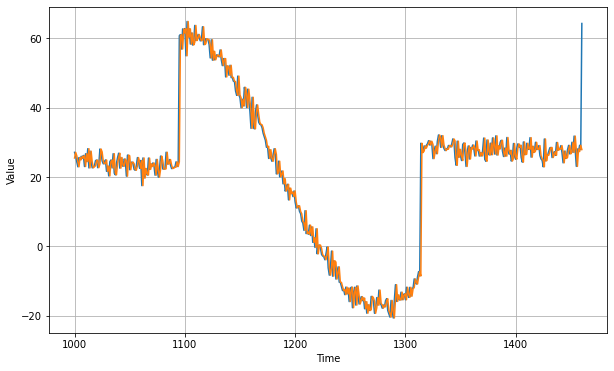

In [11]:
naive_forecast = series[split_time - 1: -1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

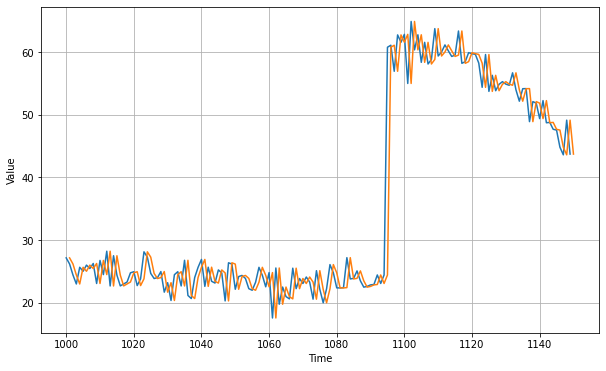

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

keras.metrics 모듈의 mean_squared_error(), mean_absolute_error() 함수는 두 시계열 데이터 간의 오차를 정량화합니다.

In [13]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

17.39385
2.5299895


## 지난 30개의 평균값으로 예측하기

In [14]:
'''moving_average_forecast() 함수'''
# window_size 동안의 평균값을 다음 예측값으로 사용
def moving_average_forecast(series, window_size):
  forecast=[]
  for time in range(len(series)-window_size):
    forecast.append(series[time : time+window_size].mean())
  return np.array(forecast)

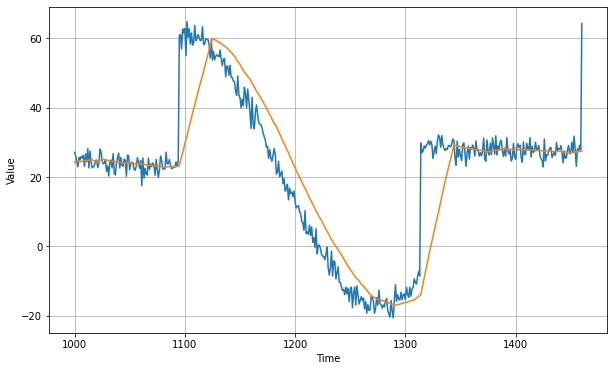

In [15]:
moving_avg = moving_average_forecast(series, 30)[split_time-30:]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [16]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

100.03572
6.221222


결론 : 지난 30개의 평균값으로 예측한 결과는 Naive Forecast보다 성능이 좋지않다.추세와 경향성을 고려하지 않기 때문이다.

->차분을 이용하여 제거하도록 하자! 계절성 주기가 365일이기 때문에 t 시간 값에서 t 시간 값 – 365를 뺀다.

**차분이란?**
- 현시점 자료에서 전 시점 자료를 빼는 것
- 일반차분(regular difference) : 바로 전 시점의 자료를 빼는법
- 계절차분(seasonal difference) : 여러 시점 전의 자료를 빼는법 ( 주로 계절성을 갖는 자료를 정상화하는데 사용 )

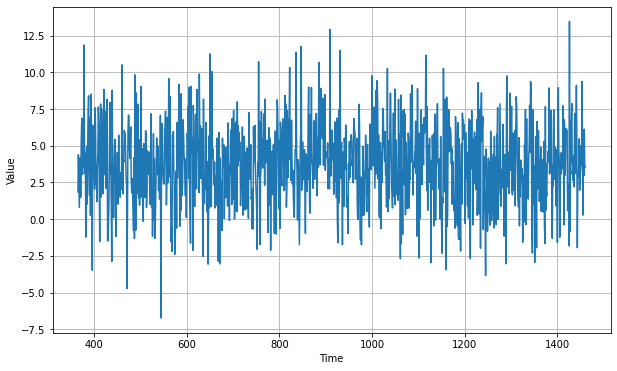

In [17]:
diff_series = (series[365:] - series[:-365]) # 365부터끝까지 / 365전까지모두
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

추세와 경향성이 제거됨 -> 이동평균법 다시 사용!

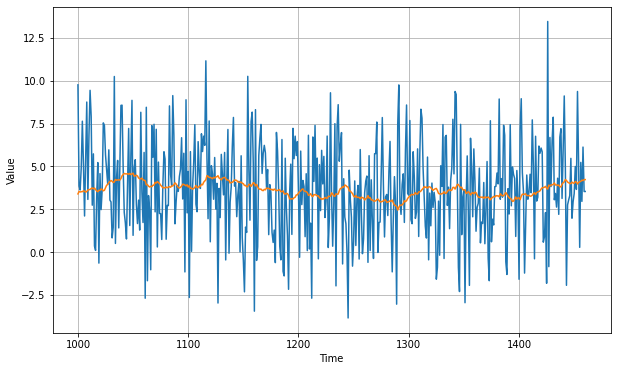

In [18]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()


이제 t – 365의 과거 값을 추가하여 추세와 계절성을 되살린다.

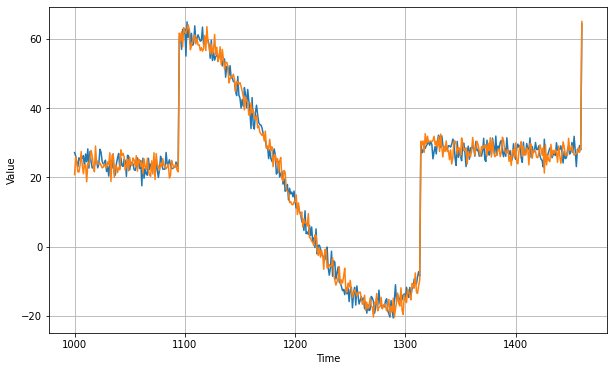

In [19]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [20]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

8.475785
2.3357244


Naive Forecast보다 낫다. 하지만 예측이 너무 무작위적으로 보임. 왜냐하면 우리는 단지 잡음이 많았던 과거 값을 덧붙이고 있기 때문임. 과거 값에 대한 이동 평균을 사용하여 일부 노이즈를 제거해 보겠다.

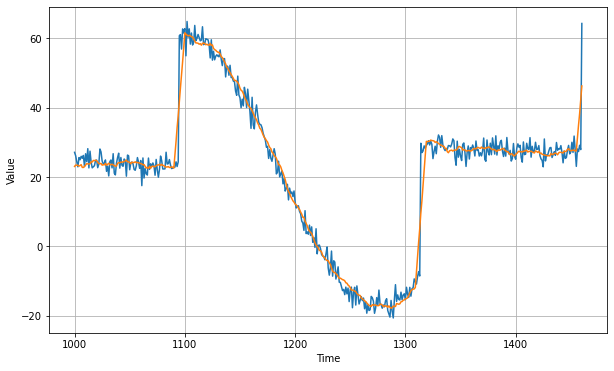

In [21]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [22]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

10.671613
2.1566694
